# UTCI changes over time

In [1]:
# Import needed packages
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import regionmask
import xarray as xr

In [2]:
# Import the data
folder = "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/BCC-CSM2-MR/"
subfolders = os.listdir(folder)
print(subfolders)
def convert_kelvin(x):
    return x - 273.15

['historical', 'ssp126', 'ssp245', 'ssp585']


In [4]:
for subfolder in subfolders[1:2]:
    ssfolders = os.listdir(os.path.join(folder, subfolder))
    print(ssfolders)
    for ssfolder in ssfolders[:2]:
        # files = os.listdir(os.path.join(folder, subfolder, ssfolder))
        # print(files)
        data = xr.open_mfdataset(os.path.join(folder, subfolder, ssfolder, "*.nc"), concat_dim="time", engine="netcdf4")
        resample = data.resample(time="M").mean()

['r1i1p1f1']


In [65]:
popdata = pd.read_csv(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/population_data/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.asc", 
    header=None, sep=" ", skiprows=range(6), na_values=-9999
)
popdata = popdata.iloc[:, :-1]
popdata = popdata.iloc[::-1, :]
popdata.columns = resample.lon.values
popdata_xr = popdata.set_index(resample.lat.values, drop=True)
popdata_xr = xr.DataArray(popdata, dims=("lat", "lon"))
popdata_xr = popdata_xr.assign_coords(lat=resample.lat.values)
popdata_xr = popdata_xr.assign_coords(lon=resample.lon.values)
popdata_xr

<xarray.DataArray (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

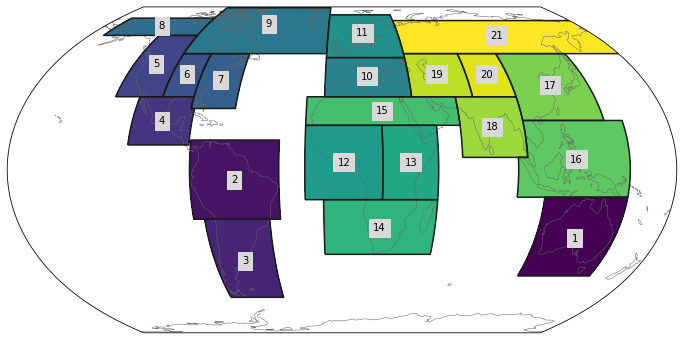

In [5]:
mask = regionmask.defined_regions.giorgi.mask(resample)
proj = ccrs.EqualEarth()
f = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=proj)
#ax.set_global()
mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.coastlines()
regionmask.defined_regions.giorgi.plot(
    ax=ax, coastlines=True
)

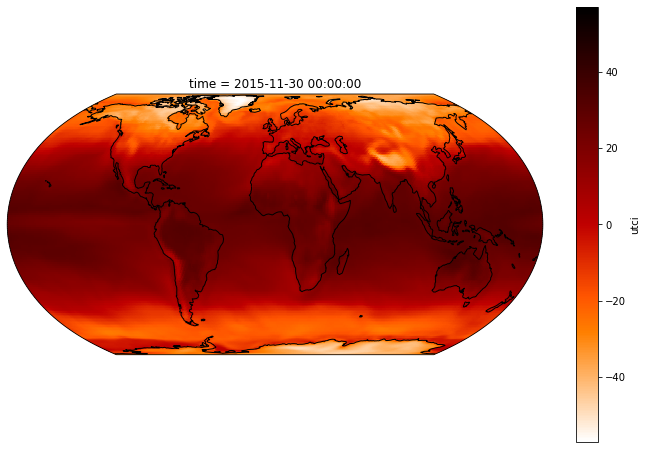

In [6]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines()

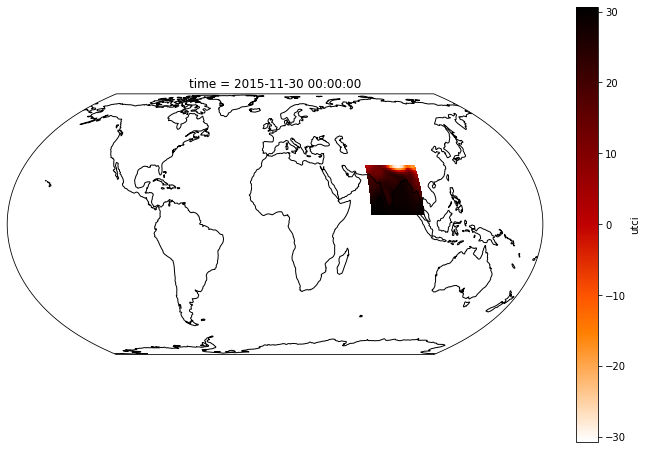

In [7]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci.where(mask==18)-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines()

In [52]:
resample.assign(pop=popdata_xr)

<xarray.Dataset>
Dimensions:   (bnds: 2, dim_0: 180, dim_1: 360, lat: 180, lon: 360, time: 1032)
Coordinates:
  * time      (time) object 2015-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * dim_0     (dim_0) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * dim_1     (dim_1) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    utci      (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    pop       (dim_0, dim_1) float64 nan nan nan nan nan ... nan nan nan nan nan

In [61]:
resample.utci.where(popdata_xr>0)

<xarray.DataArray 'utci' (time: 1032, lat: 180, lon: 360)>
dask.array<where, shape=(1032, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

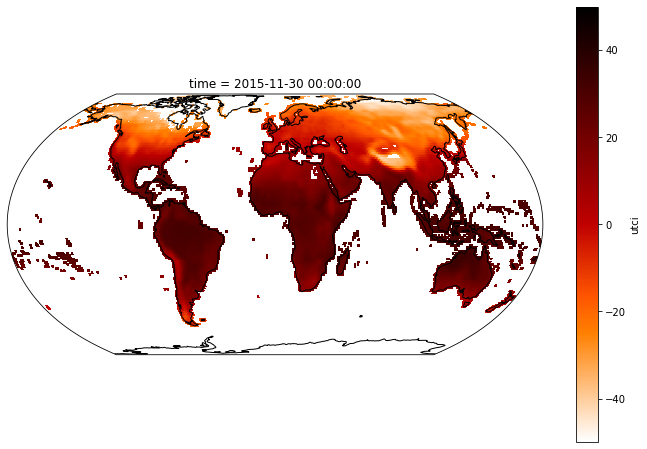

In [66]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci.where(popdata_xr>0)-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines()

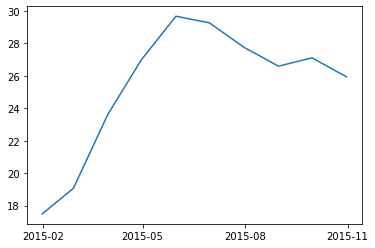

In [67]:
plt.plot(resample.time, (resample.utci.where(mask==18)-273.15).mean(["lat", "lon"]))

In [8]:
ispop = np.isfinite(popdata) * 1
ispop = xr.DataArray(ispop, dims=("lat", "lon"))
ispop

<xarray.DataArray (lat: 180, lon: 361)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360

In [20]:
ispop.sum(dim="lon")

<xarray.DataArray (lat: 180)>
array([  0,   0,   0,   0,   0,   0,  33,  70, 105, 140, 129, 129, 130,
       157, 153, 142, 154, 165, 203, 242, 278, 300, 301, 311, 315, 304,
       295, 286, 269, 267, 259, 232, 226, 224, 229, 243, 242, 251, 241,
       227, 224, 222, 223, 220, 212, 206, 202, 194, 192, 187, 186, 179,
       185, 187, 176, 172, 164, 170, 175, 174, 172, 171, 170, 165, 165,
       163, 156, 155, 161, 143, 145, 144, 132, 126, 123, 115, 109, 109,
       115, 120, 128, 131, 121, 119, 115, 106,  98,  98, 106, 109, 113,
       129, 130, 128, 122, 123, 122, 122, 124, 113, 104,  96,  91,  94,
       108, 109, 123, 117, 113, 115, 115, 120, 111, 103,  96,  92,  86,
        86,  84,  80,  76,  76,  69,  62,  58,  38,  35,  36,  31,  24,
        25,  24,  21,  23,  18,  17,  14,  12,  11,  10,  10,  13,  12,
         8,  12,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
Coordinates:
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179

In [13]:
resample

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 180, lon: 360, time: 1032)
Coordinates:
  * time      (time) object 2015-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    utci      (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>

In [9]:
popresample = resample.where(ispop==1)

In [11]:
print(popresample.utci[:4, :, :])

<xarray.DataArray 'utci' (time: 4, lat: 0, lon: 0)>
dask.array<getitem, shape=(4, 0, 0), dtype=float64, chunksize=(1, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 
  * lon      (lon) float64 
  * time     (time) object 2015-01-31 00:00:00 ... 2015-04-30 00:00:00


In [6]:
plt.plot(popresample.time[:8], popresample.utci[:8, ])

In [7]:
#plt.plot(popresample.time, popresample.utci)